In [1]:
!pip install -q gdown polars lightgbm scikit-learn imbalanced-learn matplotlib

instalasi library yang diperlukan untuk pemrosesan data, model machine learning, dan visualisasi

In [2]:
import gdown

gdown.download_folder(
    url="https://drive.google.com/drive/folders/1CUa_XTh3gr20j-_AvVj9qT0J3aoCR5s4?hl=id",
    output="regresi dataset",
    quiet=False
)

Retrieving folder contents


Processing file 1lxQCJO5wQ2pCqj_ExzJ17HtpPSbesbF3 midterm-regresi-dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1lxQCJO5wQ2pCqj_ExzJ17HtpPSbesbF3
From (redirected): https://drive.google.com/uc?id=1lxQCJO5wQ2pCqj_ExzJ17HtpPSbesbF3&confirm=t&uuid=07e8c19e-ad38-44a3-b4a1-da5eb134d01a
To: /content/regresi dataset/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:05<00:00, 78.1MB/s]
Download completed


['regresi dataset/midterm-regresi-dataset.csv']

In [3]:
import os

os.listdir("regresi dataset")

['midterm-regresi-dataset.csv']

In [4]:
import os, gc, time
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import xgboost as xgb
import joblib

meng import semua library untuk loading data, eksplorasi, preprocessing, training model ML, dan evaluasi

In [5]:
DATA_PATH = "regresi dataset/midterm-regresi-dataset.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.2

In [6]:
#load data
print("Loading dataset:", DATA_PATH)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Upload file or change DATA_PATH.")

Loading dataset: regresi dataset/midterm-regresi-dataset.csv


In [7]:
df_pl = pl.read_csv(DATA_PATH, has_header=False)

membaca dataset menggunakan *polars* agar lebih cepat dan efisien dalam memori

In [8]:
#convert to pandas
df = df_pl.to_pandas()

In [9]:
cols = df.columns.tolist()
target_col = "target"
feature_cols = [f"feature_{i}" for i in range(1, len(cols))]

In [10]:
new_cols = [target_col] + feature_cols
df.columns = new_cols #memberi nama kolom: kolom pertama adalah target, sisanya adalah fitur numerik

print("Shape:", df.shape)
print("Head:")
display(df.head())

Shape: (515345, 91)
Head:


,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [11]:
#quick EDA
print("\nBasic stats:")
display(df.describe().T[['count','mean','std','min','max']].head())


Basic stats:


,count,mean,std,min,max
target,515345.0,1998.397082,10.931046,1922.00000,2011.00000
feature_1,515345.0,43.387126,6.067558,1.74900,61.97014
feature_2,515345.0,1.289554,51.580351,-337.09250,384.06573
feature_3,515345.0,8.658347,35.268585,-301.00506,322.85143
feature_4,515345.0,1.164124,16.322790,-154.18358,335.77182


In [12]:
#check missing
missing = df.isna().sum()
print("\nMissing values (top 10):")
print(missing[missing>0].sort_values(ascending=False).head(10))


Missing values (top 10):
Series([], dtype: int64)


In [13]:
#preprocessing
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med) #menggunakan median agar tidak bias

In [14]:
def clip_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    return series.clip(lower, upper)

for c in feature_cols:
    df[c] = clip_outliers(df[c]) #clipping outlier menggunakan batas IQR agar data ekstrem tidak merusak model

In [15]:
#split features and target
X = df[feature_cols].copy()
y = df[target_col].copy().astype(float)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (412276, 90) Test shape: (103069, 90)


memisahkan data menjadi train dan test agar evaluasi lebih adil

In [17]:
#scale features
scaler = StandardScaler() #scalling fitur untuk model linear agar lebih stabil
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [18]:
#baseline models
results = {}

def eval_reg(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [19]:
#linear regression
lr = LinearRegression() #model baseline pertama sebagai pembanding
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
results['LinearRegression'] = eval_reg(y_test, pred_lr)
print("LinearRegression:", results['LinearRegression'])

LinearRegression: {'mse': 89.91573626491527, 'rmse': np.float64(9.482390851726967), 'mae': 6.754017279556343, 'r2': 0.2445009357755189}


In [20]:
#ridge
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge.fit(X_train_scaled, y_train)
pred_ridge = ridge.predict(X_test_scaled)
results['Ridge'] = eval_reg(y_test, pred_ridge)
print("Ridge:", results['Ridge'])

Ridge: {'mse': 89.91573390567659, 'rmse': np.float64(9.48239072732592), 'mae': 6.754017941806441, 'r2': 0.244500955598552}


In [32]:
#random forest
rf = RandomForestRegressor(n_estimators=50, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1) #model tree ensemble yang kuat untuk data non linear
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results['RandomForest'] = eval_reg(y_test, pred_rf)
print("RandomForest:", results['RandomForest'])

RandomForest: {'mse': 85.92928634940024, 'rmse': np.float64(9.269805086915271), 'mae': 6.50702093563331, 'r2': 0.27799628715512537}


In [24]:
#LightGBM model gradient boosting yang cepat dan akurat
lgb = LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=RANDOM_STATE)
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)
results['LightGBM'] = eval_reg(y_test, pred_lgb)
print("LightGBM:", results['LightGBM'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.504287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 412276, number of used features: 90
[LightGBM] [Info] Start training from score 1998.390333
LightGBM: {'mse': 81.16656417470811, 'rmse': np.float64(9.009248813009224), 'mae': 6.28943417305624, 'r2': 0.31801411157175197}


In [25]:
#XGBoost
xg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=RANDOM_STATE, verbosity=0)
xg.fit(X_train, y_train)
pred_xg = xg.predict(X_test)
results['XGBoost'] = eval_reg(y_test, pred_xg)
print("XGBoost:", results['XGBoost'])

XGBoost: {'mse': 80.83646662064153, 'rmse': np.float64(8.990910222032113), 'mae': 6.282169116532372, 'r2': 0.3207876905197721}


In [33]:
#show comparison table
res_df = pd.DataFrame(results).T
res_df = res_df[['mse','rmse','mae','r2']]
print("\nModel comparison:")
display(res_df.sort_values('rmse'))


Model comparison:


,mse,rmse,mae,r2
XGBoost,80.836467,8.990910,6.282169,0.320788
LightGBM,81.166564,9.009249,6.289434,0.318014
RandomForest,85.929286,9.269805,6.507021,0.277996
Ridge,89.915734,9.482391,6.754018,0.244501
LinearRegression,89.915736,9.482391,6.754017,0.244501


In [34]:
#hyperparameter tuning
print("\nHyperparameter tuning for LightGBM (randomized, small n_iter)...")
param_dist = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


Hyperparameter tuning for LightGBM (randomized, small n_iter)...


In [35]:
#hyperparameter tuning ringan untuk mencari parameter terbaik
search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=6,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

In [36]:
subsample_len = min(20000, len(X_train))
search.fit(X_train.iloc[:subsample_len], y_train.iloc[:subsample_len])
print("Best params:", search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 90
[LightGBM] [Info] Start training from score 1998.345000
Best params: {'subsample': 0.8, 'num_leaves': 63, 'n_estimators': 400, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [37]:
best_lgb = search.best_estimator_
pred_best = best_lgb.predict(X_test)
results['LightGBM_tuned'] = eval_reg(y_test, pred_best)
print("LightGBM_tuned:", results['LightGBM_tuned'])

LightGBM_tuned: {'mse': 85.17832551339681, 'rmse': np.float64(9.229210449079423), 'mae': 6.5062615656667315, 'r2': 0.2843060860005495}


In [38]:
#final evaluation plot (pred vs actual) for best model
best_model_name = min(results, key=lambda k: results[k]['rmse'])
print("\nBest model by RMSE:", best_model_name)


Best model by RMSE: XGBoost


In [39]:
pred_map = {
    'LinearRegression': pred_lr,
    'Ridge': pred_ridge,
    'RandomForest': pred_rf,
    'LightGBM': pred_lgb,
    'XGBoost': pred_xg,
    'LightGBM_tuned': pred_best
}
y_pred_best = pred_map[best_model_name]

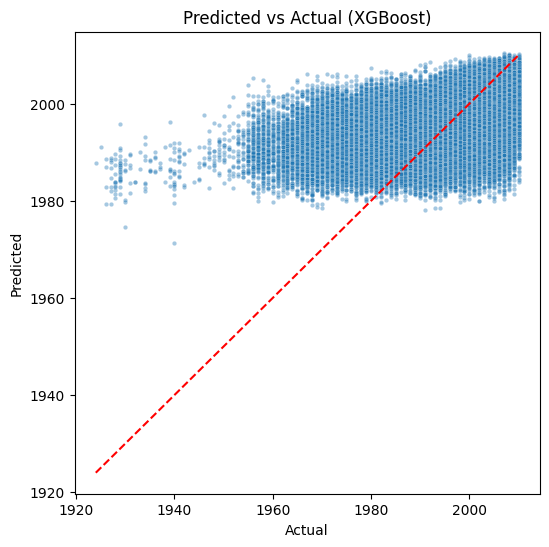

In [40]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual ({best_model_name})")
plt.show()

In [41]:
#save best model + scaler
os.makedirs("models", exist_ok=True)
joblib.dump(best_lgb, "models/best_lgb_model.joblib") #menyimpan model akhir agar bisa digunakan kembali tanpa retraining
joblib.dump(scaler, "models/scaler.joblib")
print("Saved model -> models/best_lgb_model.joblib and scaler -> models/scaler.joblib")

Saved model -> models/best_lgb_model.joblib and scaler -> models/scaler.joblib


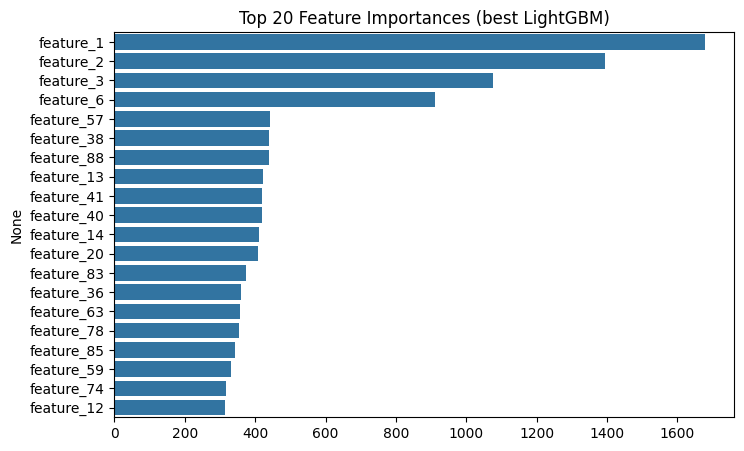

In [42]:
#simple interpretation feature importance
if hasattr(best_lgb, "feature_importances_"):
    fi = pd.Series(best_lgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,5))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title("Top 20 Feature Importances (best LightGBM)")
    plt.show()

In [44]:
print("\ndone guysss.summary:")
print(" - Models trained: Linear, Ridge, RandomForest, LightGBM, XGBoost")
print(" - Tuned LightGBM with RandomizedSearchCV (small n_iter)")
print(" - Metrics reported: MSE, RMSE, MAE, R2")
print(" - Best model saved to models/best_lgb_model.joblib")


done guysss.summary:
 - Models trained: Linear, Ridge, RandomForest, LightGBM, XGBoost
 - Tuned LightGBM with RandomizedSearchCV (small n_iter)
 - Metrics reported: MSE, RMSE, MAE, R2
 - Best model saved to models/best_lgb_model.joblib
